In [1]:
import pandas as pd
import glob
import os
import sys
import re
from collections import defaultdict
import ipaddress
import pickle
import json
from IPython.display import clear_output


In [2]:
sys.path.append("../src")
from cert import Cert, Chain
from truststore import *
from validator import ChainValidator, CertValidator
from utils import *

### Config Directories

In [14]:
hybrid_datadir = "../data/hybrid_chain/"
nonpub_datadir = "../data/nonpub_chain/"

### Read TrustStores
Read truststores from dir:"truststores"

In [5]:
config = {
        "ccadb": "truststores/ccadb.txt",
        "truststore": "truststores/truststores.txt",
        "whitelist": "truststores/whitelist.txt",
        "interception": "truststores/interception.txt",
        "cross-sign-g1": "truststores/cross-signing_g1.txt",
        "cross-sign-g2": "truststores/cross-signing_g2.txt",
    }

CertStoresDict = {
    "ccadb": load_set(config["ccadb"]),
    "whitelist": load_set(config["whitelist"]),
    "truststore": load_set(config["truststore"]),
    "interception": load_set(config["interception"]),
    "peerCrossSigned": load_set(config["interception"]),
    "strictCrossSigned": load_set(config["interception"])
}


In [6]:
myTrustStore = TrustStores(CertStoresDict)

### Init Validator

In [34]:
myCertValidator = CertValidator(myTrustStore)
myChainValidator = ChainValidator(myCertValidator)

## Analyze Hybrid Chain

In [15]:
hybrid_fl = glob.glob((hybrid_datadir+ "csv/*.csv"))
print(len(hybrid_fl))

270


In [31]:
## read parsed csv certficate chains
hybrid_fqdns = []
hybrid_chains = []

for f in hybrid_fl:
    tmpdf = pd.read_csv(f)
    tmpfqdn = f.split("/")[-1].split(".csv")[0]
    
    chain = Chain()
    for idx, item in tmpdf.iterrows():    
        ## init certficate data
        data = defaultdict(str, {"Issuer": item['Issuer'], 
                                 "Subject":item["Subject"]})
        chain.append(data)

    # add to chain and fqdn list
    hybrid_chains.append(chain)
    hybrid_fqdns.append(tmpfqdn)

In [72]:
hybrid_df = pd.DataFrame()
hybrid_df['fqdn'] = hybrid_fqdns
hybrid_df['chain_obj'] = hybrid_chains

In [73]:
## analysis
hybrid_df["chain_len"] = hybrid_df["chain_obj"].apply(lambda x: len(x.to_list()))
hybrid_df["cert_chain_status"] = hybrid_df["chain_obj"].apply(lambda x: json.dumps(myChainValidator.get_certstatus_in_chain(x)))
hybrid_df["cert_chain_issuer_pub"] = hybrid_df["cert_chain_status"].apply(lambda x: get_issuer_status(x))
hybrid_df["chain_category"] = hybrid_df["cert_chain_issuer_pub"].apply(lambda x: get_chain_category(x))
# mismatches
hybrid_df["chain_mismatches"] = hybrid_df["chain_obj"].apply(lambda x: myChainValidator.count_mismatches(x))

# subchains
hybrid_df["subchains_cnt"] = hybrid_df["chain_obj"].apply(lambda x: myChainValidator.count_subchains(x)[0])
hybrid_df["subchains_idx"] = hybrid_df["chain_obj"].apply(lambda x: myChainValidator.count_subchains(x)[1])
hybrid_df["subchains_totalcert"] = hybrid_df["subchains_idx"].apply(lambda x: count_certs_in_subchains(x))

# chain is valid
hybrid_df["allcert_matches"] = (hybrid_df["subchains_totalcert"] == hybrid_df["chain_len"])    

# leafs
hybrid_df[['PubLeaf_cnt', 'PubLeaf_idx', 'PrivLeaf_cnt', 'PrivLeaf_idx']] = hybrid_df['chain_obj'].apply(myChainValidator.count_leafs).apply(pd.Series)
hybrid_df["Leaf_total"] = hybrid_df["PubLeaf_cnt"] + hybrid_df['PrivLeaf_cnt']

def update_leafs(pub_leaf_idx, priv_leaf_idx):
    leaf_idx = set()
    leaf_idx.update(priv_leaf_idx)
    leaf_idx.update(pub_leaf_idx)
    return leaf_idx

hybrid_df["Leaf_idx"] = hybrid_df.apply(lambda x: update_leafs(x['PubLeaf_idx'], x['PrivLeaf_idx']), axis=1)

hybrid_df["isSelfsigned"] = hybrid_df['chain_obj'].apply(lambda x: myChainValidator.isOnlySelfSigned(x))
hybrid_df["isCompleteChain"] = hybrid_df.apply(lambda x: isCompleteChain(x['subchains_cnt'], x['allcert_matches']), axis=1)

hybrid_df["leaf_in_subchains"] = hybrid_df.apply(lambda x: valid_subchain(x['subchains_idx'], x['Leaf_idx']), axis=1)
hybrid_df["cntCompleteChains"] = hybrid_df.apply(lambda x: containCompleteChain(x['leaf_in_subchains'], x['subchains_cnt']), axis=1)

In [74]:
hybrid_df.shape

(270, 21)

In [75]:
def get_chain_category(issuer_pub_l):
    if all([i == "Pub" for i in issuer_pub_l]):
        return "AllPub"
    elif all([i == "Priv" for i in issuer_pub_l]):
        return "AllPriv"
    return "Hybrid"

In [76]:
## chain categories 
hybrid_df["chain_category"].value_counts()

chain_category
AllPub     231
Hybrid      35
AllPriv      4
Name: count, dtype: int64

In [77]:
hybrid_df.loc[hybrid_df["chain_category"]=="Hybrid"]["isCompleteChain"].value_counts()

isCompleteChain
False    26
True      9
Name: count, dtype: int64

In [78]:
# 3 contains a complete chain 
hybrid_df_non_complete = hybrid_df.loc[hybrid_df["chain_category"]=="Hybrid"].loc[hybrid_df["isCompleteChain"]==False]
hybrid_df_non_complete["cntCompleteChains"].value_counts()

cntCompleteChains
 0    14
-1     9
 1     3
Name: count, dtype: int64

In [79]:
hybrid_df_non_complete.loc[hybrid_df_non_complete["cntCompleteChains"]==1]

,fqdn,chain_obj,chain_len,cert_chain_status,cert_chain_issuer_pub,chain_category,chain_mismatches,subchains_cnt,subchains_idx,subchains_totalcert,...,PubLeaf_cnt,PubLeaf_idx,PrivLeaf_cnt,PrivLeaf_idx,Leaf_total,Leaf_idx,isSelfsigned,isCompleteChain,leaf_in_subchains,cntCompleteChains
62,artswarandpeace.univ-paris-diderot.fr,<cert.Chain object at 0x1779a26f0>,9,"[{""isSubjectCNFQDN"": true, ""isPublic"": true, ""...","[Pub, Pub, Pub, Pub, Priv, Pub, Pub, Pub, Pub]",Hybrid,3,3,"[{0, 1, 2, 3}, {5, 6}, {8, 7}]",8,...,1,{0},0,{},1,{0},False,False,"[[True, False, False, False], [False, False], ...",1
68,larca.univ-paris-diderot.fr,<cert.Chain object at 0x1779a3200>,9,"[{""isSubjectCNFQDN"": true, ""isPublic"": true, ""...","[Pub, Pub, Pub, Pub, Priv, Pub, Pub, Pub, Pub]",Hybrid,3,3,"[{0, 1, 2, 3}, {5, 6}, {8, 7}]",8,...,1,{0},0,{},1,{0},False,False,"[[True, False, False, False], [False, False], ...",1
214,listes.univ-paris-diderot.fr,<cert.Chain object at 0x177a01880>,9,"[{""isSubjectCNFQDN"": true, ""isPublic"": true, ""...","[Pub, Pub, Pub, Pub, Priv, Pub, Pub, Pub, Pub]",Hybrid,3,3,"[{0, 1, 2, 3}, {5, 6}, {8, 7}]",8,...,1,{0},0,{},1,{0},False,False,"[[True, False, False, False], [False, False], ...",1


## Analyze Non-Pub Chain

In [81]:
# read fqdn
fl = glob.glob(os.path.join(nonpub_datadir, "csv", "*/*.csv"))

In [82]:
len(fl)

12404

In [133]:
cnt = 0 
fqdn_l = []
chain_l = []
for f in fl:
    tmpfqdn = f.split("/")[-1][:-4] # rstrip ".csv"

    tmpdf = pd.read_csv(f, delimiter="|")
    if tmpdf.shape[0] == 0:
        continue
    chain = Chain()
    for idx, item in tmpdf.iterrows():    
        ## init certficate data
        issuer = "" if type(item['Issuer']) != str else item['Issuer']
        subject = "" if type(item['Subject']) != str else item["Subject"]
        
        data = defaultdict(str, {"Issuer": issuer, 
                                 "Subject":subject})
        chain.append(data)
    fqdn_l.append(tmpfqdn)
    chain_l.append(chain)
    cnt += 1
print(cnt)

12404


In [134]:
privdf = pd.DataFrame()
privdf['fqdn'] = fqdn_l
privdf['chain_obj'] = chain_l

In [135]:
privdf.shape

(12404, 2)

In [138]:
privdf["chain_len"] = privdf["chain_obj"].apply(lambda x: len(x.to_list()))
privdf["cert_chain_status"] = privdf["chain_obj"].apply(lambda x: json.dumps(myChainValidator.get_certstatus_in_chain(x)))
privdf["cert_chain_issuer_pub"] = privdf["cert_chain_status"].apply(lambda x:get_issuer_status(x))
privdf["chain_category"] = privdf["cert_chain_issuer_pub"].apply(lambda x: get_chain_category(x))

# mismatches
privdf["chain_mismatches"] = privdf["chain_obj"].apply(lambda x: myChainValidator.count_mismatches(x))

# subchains
privdf["subchains_cnt"] = privdf["chain_obj"].apply(lambda x: myChainValidator.count_subchains(x)[0])
privdf["subchains_idx"] = privdf["chain_obj"].apply(lambda x: myChainValidator.count_subchains(x)[1])
privdf["subchains_totalcert"] = privdf["subchains_idx"].apply(lambda x: count_certs_in_subchains(x))

# chain is valid
privdf["allcert_matches"] = (privdf["subchains_totalcert"] == privdf["chain_len"])    

# leafs

privdf[['PubLeaf_cnt', 'PubLeaf_idx', 'PrivLeaf_cnt', 'PrivLeaf_idx']] = privdf['chain_obj'].apply(myChainValidator.count_leafs).apply(pd.Series)
privdf["Leaf_total"] = privdf["PubLeaf_cnt"] + privdf['PrivLeaf_cnt']


privdf["Leaf_idx"] = privdf.apply(lambda x:update_leafs(x['PubLeaf_idx'], x['PrivLeaf_idx']), axis=1)

privdf["isOnlySelfSigned"] = privdf['chain_obj'].apply(lambda x: myChainValidator.isOnlySelfSigned(x))
privdf["isCompleteChain"] = privdf.apply(lambda x: isCompleteChain(x['subchains_cnt'], x['allcert_matches']), axis=1)

privdf["leaf_in_subchains"] = privdf.apply(lambda x: valid_subchain(x['subchains_idx'], x['Leaf_idx']), axis=1)
privdf["cntCompleteChains"] = privdf.apply(lambda x: containCompleteChain(x['leaf_in_subchains'], x['subchains_cnt']), axis=1)


In [139]:
## chain categories 
privdf["chain_category"].value_counts()

chain_category
AllPriv    12404
Name: count, dtype: int64

<Axes: >

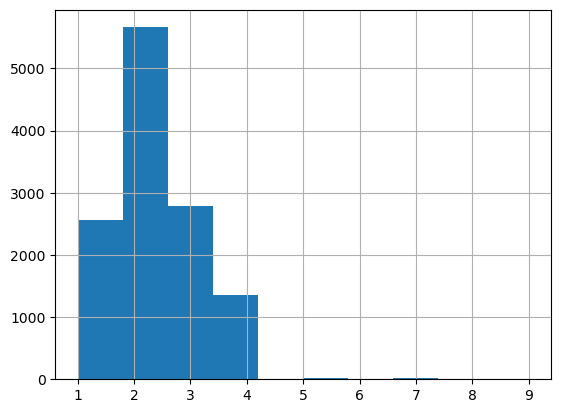

In [140]:
privdf["chain_len"].hist()

In [142]:
privdf.loc[privdf["chain_len"]>1].shape

(9849, 21)

In [77]:
privdf.loc[privdf["chain_category"]=="Hybrid"]["isCompleteChain"].value_counts()

isCompleteChain
False    26
True      9
Name: count, dtype: int64